# ***Import Libraries***

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Dropout, BatchNormalization, Layer
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# ***Load and Visualize Data***

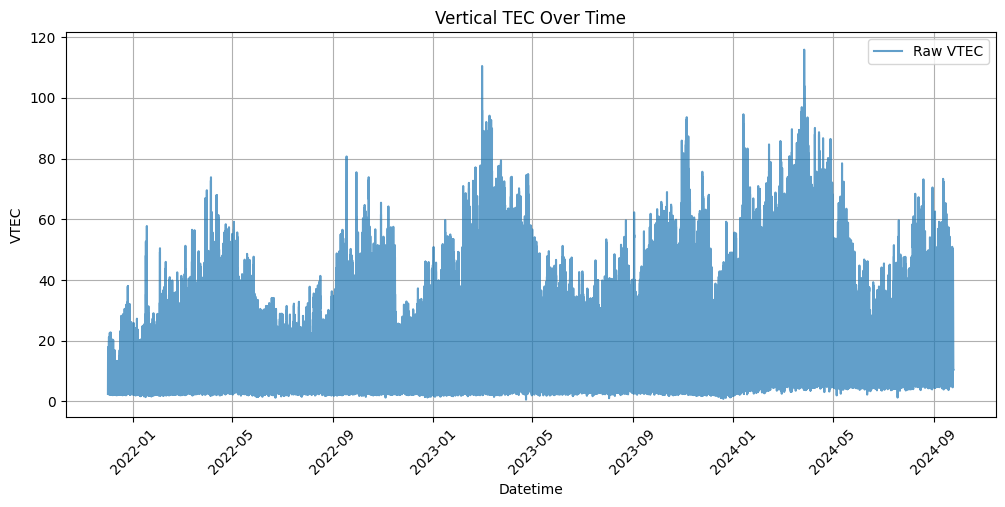

In [2]:
# Dataset path
file_path = "D:\\Graduation Project V3\\final north data.xlsx"

# Load and sort by location then datetime
df = pd.read_excel(file_path)
df["datetime"] = pd.to_datetime(df["datetime"])
df.sort_values(by=["datetime"], inplace=True)

# Plot VTEC evolution
plt.figure(figsize=(12, 5))
plt.plot(df["datetime"], df["Average_TEC"], label="Raw VTEC", alpha=0.7)
plt.title("Vertical TEC Over Time")
plt.xlabel("Datetime")
plt.ylabel("VTEC")
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.show()

# ***Data Preprocessing***

In [ ]:
test_days = [("North", "2024-07-28")]


# Final feature list
features = [
    "Average_Lat", "Average_Long", "Average_BS", "Average_BZ", "Average_SWD",
    "Average_SWS", "Average_EF", "Average_Kp", "Average_Rs", "Average_Dst",
    "Average_f10", "Average_MagMN", "VTEC_EMA_4day", "VTEC_EMA_30day",
    "VTEC_derivative_1st", "VTEC_derivative_2nd", "VTEC_lag_1", "VTEC_lag_24",
    "HoD_sin", "HoD_cos", "DoY_sin", "DoY_cos"
]
target = "Average_TEC"

# MinMax scaling
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
df[features] = scaler_X.fit_transform(df[features])
df[target] = scaler_y.fit_transform(df[[target]])

# ***Create Dataset Function and Split Data***

In [4]:
def create_sequences(data, feat_cols, targ_col, lookback):
    X_seq, y_seq, time_seq = [], [], []
    for i in range(len(data) - lookback):
        X_block = data.iloc[i:i+lookback][feat_cols].values
        y_val = data.iloc[i+lookback][targ_col]
        hour_val = data.iloc[i+lookback]["Hour"]
        X_seq.append(X_block)
        y_seq.append(y_val)
        time_seq.append(hour_val)
    return np.array(X_seq), np.array(y_seq), np.array(time_seq).reshape(-1, 1)

lookback_window = 72
train_size = int(len(df) * 0.8)

df_train = df.iloc[:train_size]
df_test = df.iloc[train_size:]

X_train, y_train, T_train = create_sequences(df_train, features, target, lookback_window)
X_test, y_test, T_test = create_sequences(df_test, features, target, lookback_window)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape: ", X_test.shape, y_test.shape)

Train shape: (591487, 72, 22) (591487,)
Test shape:  (147818, 72, 22) (147818,)


# ***Build and Train LSTM Model***

In [5]:
class DayNightPenalty(Layer):
    def __init__(self, vtec_night_limit=10.0, vtec_day_min=30.0, penalty_scale=0.1, **kwargs):
        super(DayNightPenalty, self).__init__(**kwargs)
        self.vtec_night_limit = vtec_night_limit
        self.vtec_day_min = vtec_day_min
        self.penalty_scale = penalty_scale

    def call(self, inputs, **kwargs):
        vtec_pred, hour_val = inputs
        is_night = tf.cast(tf.logical_or(hour_val < 6, hour_val > 18), tf.float32)
        is_day = 1.0 - is_night
        night_excess = tf.nn.relu(vtec_pred - self.vtec_night_limit)
        day_deficit = tf.nn.relu(self.vtec_day_min - vtec_pred)
        penalty = self.penalty_scale * (is_night * night_excess + is_day * day_deficit)
        self.add_loss(tf.reduce_mean(penalty))
        return vtec_pred

In [6]:
def build_lstm_model(lookback, num_features, vtec_night_limit=10.0, vtec_day_min=30.0, penalty_scale=0.1):
    feature_input = Input(shape=(lookback, num_features), name="FeatureInput")
    hour_input = Input(shape=(1,), name="HourInput")

    x = Bidirectional(LSTM(128, return_sequences=True, activation='tanh'))(feature_input)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Bidirectional(LSTM(64, return_sequences=True, activation='tanh'))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Bidirectional(LSTM(32, activation='tanh'))(x)
    x = Dropout(0.3)(x)

    x = Dense(64, activation='swish')(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='swish')(x)

    vtec_pred = Dense(1, name="VTEC_Pred")(x)
    final_out = DayNightPenalty(vtec_night_limit, vtec_day_min, penalty_scale)([vtec_pred, hour_input])

    model = Model(inputs=[feature_input, hour_input], outputs=final_out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss="mse", metrics=["mae"])
    return model

model = build_lstm_model(lookback_window, len(features))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 FeatureInput (InputLayer)   [(None, 72, 22)]             0         []                            
                                                                                                  
 bidirectional (Bidirection  (None, 72, 256)              154624    ['FeatureInput[0][0]']        
 al)                                                                                              
                                                                                                  
 batch_normalization (Batch  (None, 72, 256)              1024      ['bidirectional[0][0]']       
 Normalization)                                                                                   
                                                                                              

In [7]:
# === Define Callbacks ===
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ModelCheckpoint("best_model.h5", save_best_only=True, monitor='val_loss', verbose=1)  # Save in .h5 format
]

# === Train the Model ===
history = model.fit(
    [X_train, T_train],
    y_train,
    validation_data=([X_test, T_test], y_test),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# === Final Save of the Model ===
model.save("final_trained_lstm_model.h5")  # Save the final model in .h5 format
print("✅ Final model saved.")

Epoch 1/100
18484/18484 [==============================] - ETA: 0s - loss: 1.6462 - mae: 0.0379
Epoch 1: val_loss improved from inf to 1.59054, saving model to best_model.h5
18484/18484 [==============================] - 2638s 142ms/step - loss: 1.6462 - mae: 0.0379 - val_loss: 1.5905 - val_mae: 0.0399 - lr: 0.0010
Epoch 2/100
    1/18484 [..............................] - ETA: 32:00 - loss: 1.4878 - mae: 0.0378

c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


18484/18484 [==============================] - ETA: 0s - loss: 1.6457 - mae: 0.0349
Epoch 2: val_loss improved from 1.59054 to 1.59033, saving model to best_model.h5
18484/18484 [==============================] - 2206s 119ms/step - loss: 1.6457 - mae: 0.0349 - val_loss: 1.5903 - val_mae: 0.0352 - lr: 0.0010
Epoch 3/100
18484/18484 [==============================] - ETA: 0s - loss: 1.6456 - mae: 0.0340
Epoch 3: val_loss improved from 1.59033 to 1.59032, saving model to best_model.h5
18484/18484 [==============================] - 2195s 119ms/step - loss: 1.6456 - mae: 0.0340 - val_loss: 1.5903 - val_mae: 0.0345 - lr: 0.0010
Epoch 4/100
18484/18484 [==============================] - ETA: 0s - loss: 1.6455 - mae: 0.0335
Epoch 4: val_loss did not improve from 1.59032
18484/18484 [==============================] - 2187s 118ms/step - loss: 1.6455 - mae: 0.0335 - val_loss: 1.5904 - val_mae: 0.0336 - lr: 0.0010
Epoch 5/100
18484/18484 [==============================] - ETA: 0s - loss: 1.6455 - 

# ***Evaluate Model on Test Set***

In [8]:
y_pred_scaled = model.predict([X_test, T_test])
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_true = scaler_y.inverse_transform(y_test.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE:  {mae:.4f}")

4620/4620 [==============================] - 198s 42ms/step
Test RMSE: 5.0954
Test MAE:  3.9782
